In [34]:
import numpy as np
import tensorflow as tf
import os
import sys
import random

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [37]:
input_shape=(128, 128, 3)
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

In [19]:
TRAIN_PATH='stage1_train/'
TEST_PATH='stage1_test/'

In [29]:
# Names of 
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [32]:
X_train = np.zeros((len(train_ids), input_shape[0], input_shape[1], input_shape[2]), dtype='uint8')
Y_train = np.zeros((len(train_ids), input_shape[0], input_shape[1], 1), dtype='bool')

### Resizing training images and masks

In [38]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask 

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:47<00:00,  6.24it/s]


### Test images 

In [41]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

  0%|                                                                                           | 0/65 [00:00<?, ?it/s]

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 67.00it/s]


### Check images and the masks

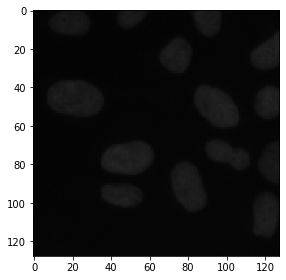

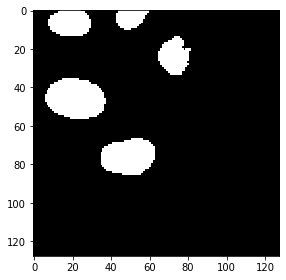

In [42]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

### Build Model

In [4]:
inputs=tf.keras.layers.Input(input_shape)
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

### Contraction Path

In [5]:
c1=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=tf.keras.layers.MaxPooling2D((2, 2))(c1)
print(p1)

KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 16), dtype=tf.float32, name=None), name='max_pooling2d/MaxPool:0', description="created by layer 'max_pooling2d'")


In [6]:
c2=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)
print(p2)

KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 32), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")


In [7]:
c3=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)
print(p3)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name=None), name='max_pooling2d_2/MaxPool:0', description="created by layer 'max_pooling2d_2'")


In [8]:
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
print(p4)

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 128), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")


In [9]:
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

### Expansive Layer

The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution.

In [10]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

In [11]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

In [12]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

In [13]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [14]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [15]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
model.save('u_net.h5')

### Checkpoints and Callbacks

In [43]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [45]:
result = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 52s 1s/step - loss: 0.5780 - accuracy: 0.8421 - val_loss: 0.2812 - val_accuracy: 0.8673
Epoch 2/25
38/38 [==============================] - 47s 1s/step - loss: 0.2823 - accuracy: 0.8604 - val_loss: 0.1658 - val_accuracy: 0.9354
Epoch 3/25
38/38 [==============================] - 47s 1s/step - loss: 0.1651 - accuracy: 0.9384 - val_loss: 0.1321 - val_accuracy: 0.9446
Epoch 4/25
38/38 [==============================] - 47s 1s/step - loss: 0.1301 - accuracy: 0.9490 - val_loss: 0.1078 - val_accuracy: 0.9569
Epoch 5/25
38/38 [==============================] - 47s 1s/step - loss: 0.1108 - accuracy: 0.9562 - val_loss: 0.1031 - val_accuracy: 0.9589
Epoch 6/25
38/38 [==============================] - 49s 1s/step - loss: 0.1009 - accuracy: 0.9609 - val_loss: 0.0947 - val_accuracy: 0.9615
Epoch 7/25
38/38 [==============================] - 47s 1s/step - loss: 0.0962 - accuracy: 0.9624 - val_loss: 0.0928 - val_accuracy: 0.9636
Epoch 8/25
38/38 [==

In [46]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 1s 179ms/step


In [47]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

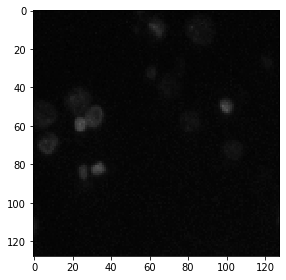

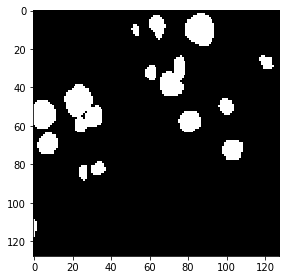

C:\Users\user\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


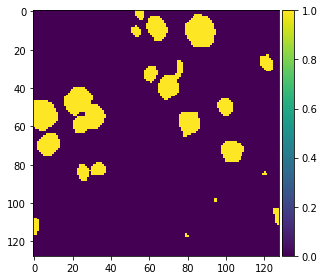

In [48]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

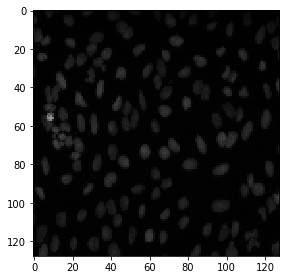

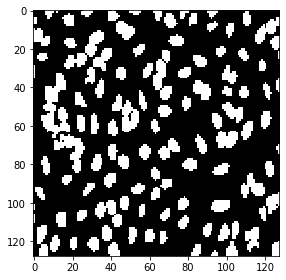

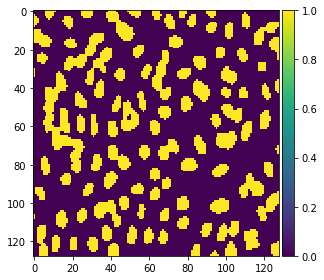

In [49]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()